# Diffusion Model

### Load modules & datasets

In [1]:
# === Train Conditional Diffusion Model on VAE Embeddings with Classifier-Based Guidance ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import scanpy as sc
import scipy.sparse as sp
import pandas as pd
import anndata as ad
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import umap
import numpy as np
import math

/projects/b1042/GoyalLab/jaekj/python/DL_py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load Data

In [3]:
batch_size = 128 

# Only load the train and validation sets for training
z_train_np = np.load('z_train.npy')
z_val_np = np.load('z_val.npy')

z_train = torch.tensor(z_train_np, dtype=torch.float32)
z_val = torch.tensor(z_val_np, dtype=torch.float32)

y_train_np = np.load('y_train.npy')
y_val_np = np.load('y_val.npy')

y_train = torch.tensor(y_train_np, dtype=torch.long)
y_val = torch.tensor(y_val_np, dtype=torch.long)

# Create data loaders
train_loader = DataLoader(TensorDataset(z_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(z_val, y_val), batch_size=batch_size, shuffle=False)

In [4]:
z_train.shape, z_val.shape

(torch.Size([67808, 256]), torch.Size([8476, 256]))

In [5]:
# check whether all train/val/test have all labels
print(len(y_train.unique()))
print(len(y_val.unique()))

100
100


#### Scheduling

In [6]:
def sigmoid_schedule(T, beta_min, beta_max, low: float = -6, high: float = 6):
    t = torch.linspace(low, high, T)
    betas = torch.sigmoid(t) * (beta_max - beta_min) + beta_min
    return betas.clamp(max=0.999)

In [7]:
T = 1000
beta_min=1e-5
beta_max=0.022
low = -6
high = 6

In [8]:
betas = sigmoid_schedule(T, beta_min=beta_min, beta_max=beta_max, low=low, high=high)

Final alpha value:  tensor(1.5002e-05)


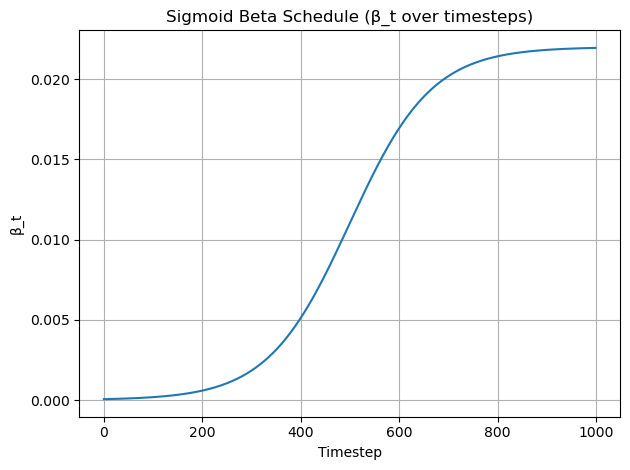

In [9]:
def plot_schedules(T, betas):
    alphas = 1.0 - betas
    alpha_bar = np.cumprod(alphas, axis=0)
    print("Final alpha value: ",alpha_bar[-1])

    # Plot beta
    plt.figure()
    plt.plot(np.arange(T), betas)
    plt.title(f"Sigmoid Beta Schedule (β_t over timesteps)")
    plt.xlabel("Timestep")
    plt.ylabel("β_t")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot alpha_bar
    plt.figure()
    plt.plot(np.arange(T), alpha_bar)
    plt.title("Cumulative ᾱ (product of (1 - β))")
    plt.xlabel("Timestep")
    plt.ylabel("ᾱ_t")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_schedules(T=T, betas=betas)

In [10]:
# ===== Model Configs =====
latent_dim = z_train.shape[1]
time_dim = 64
label_emb_dim = 64
epochs = 500
lr = 3e-4
min_lr = 1e-6
adam_betas = (0.9, 0.999)
wd_model = 1e-7
ema_decay = 0.9995
classifier_free_prob = 0.2

# learing rate scheduling 
warm_up_rate = 0.05

# early-stop parameters
patience = 30 # number of epochs to wait for improvement
patience_counter = 0

In [11]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        """
        t: LongTensor [B] of timesteps in [0, T)
        returns: [B, dim] sinusoidal embedding
        """
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t.float().unsqueeze(1) * emb.unsqueeze(0)  # [B, half_dim]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        if self.dim % 2 == 1:  # pad if dim is odd
            emb = torch.cat([emb, torch.zeros(t.size(0), 1, device=t.device)], dim=1)
        return emb

class CrossAttention(nn.Module):
    def __init__(self, feature_dim, cond_dim, heads=4, dim_head=64):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_q = nn.Linear(feature_dim, inner_dim, bias=False)
        self.to_k = nn.Linear(cond_dim, inner_dim, bias=False)
        self.to_v = nn.Linear(cond_dim, inner_dim, bias=False)
        self.to_out = nn.Linear(inner_dim, feature_dim)

    def forward(self, x, cond):
        B = x.shape[0]
        H = self.heads
        inner_dim = self.to_q.out_features
        d = inner_dim // H

        # compute queries, keys, values
        q = self.to_q(x).view(B, H, d)       # [B, H, d]
        k = self.to_k(cond).view(B, H, d)    # [B, H, d]
        v = self.to_v(cond).view(B, H, d)    # [B, H, d]

        # standard scaled dot-product attention across feature dimension
        attn_scores = torch.einsum('bhd,bhd->bh', q, k) / (d ** 0.5)  # or use self.scale
        attn_weights = torch.softmax(attn_scores, dim=-1).unsqueeze(-1)  # [B, H, 1]

        # weighted sum of values per head
        out = (attn_weights * v).reshape(B, -1)  # [B, inner_dim]
        return self.to_out(out) + x

class FiLM(nn.Module):
    def __init__(self, cond_dim, feature_dim):
        super().__init__()
        self.proj = nn.Linear(cond_dim, feature_dim * 2)
        # initialize to near-identity: gamma around 1, beta around 0
        nn.init.zeros_(self.proj.weight)
        nn.init.zeros_(self.proj.bias)

    def forward(self, x, cond):
        gamma_beta = self.proj(cond)  # [B, 2*feature_dim]
        gamma, beta = torch.chunk(gamma_beta, 2, dim=1)
        # make scaling residual to keep initial behavior stable
        gamma = 1.0 + 0.1 * torch.tanh(gamma)
        return gamma * x + beta
    
    
class ConditionalDenoiser(nn.Module):  # Two-stage cascade, tabular-friendly
    def __init__(
        self,
        T,
        latent_dim,
        time_dim,
        n_classes,
        label_emb_dim=64,
        classifier_free_prob: float = 0.0,
    ):
        super().__init__()
        self.T = T
        self.latent_dim = latent_dim
        self.time_dim = time_dim
        self.n_classes = n_classes
        self.label_emb_dim = label_emb_dim
        self.classifier_free_prob = classifier_free_prob

        # Embeddings
        self.label_emb = nn.Embedding(n_classes + 1, label_emb_dim)  # add one extra for null
        self.embed_time = SinusoidalTimeEmbedding(time_dim)
        
        self.null_idx = n_classes  # index for “null”
        self.cond_dim = time_dim + label_emb_dim  # now includes label_emb_dim

        self.lin1 = nn.Linear(latent_dim + self.cond_dim, 512)
        self.out1 = nn.Linear(512, latent_dim)

        self.fc1 = nn.Linear(512, 512)
        self.ln1 = nn.LayerNorm(512)
        
        self.attn1 = CrossAttention(512, self.cond_dim)
        self.film1 = FiLM(self.cond_dim, 512)
        self.dropout1 = nn.Dropout(0.1)

        self.lin2 = nn.Linear(latent_dim*2 + self.cond_dim, 2048)
        self.out2 = nn.Linear(2048, latent_dim)

        self.fc2 = nn.Linear(2048, 2048)
        self.ln2 = nn.LayerNorm(2048)
        self.attn2 = CrossAttention(2048, self.cond_dim)
        self.film2 = FiLM(self.cond_dim, 2048)
        self.dropout2 = nn.Dropout(0.1)

        self.betas = None

    def forward(self, zt, t, y_label):
        # --- Classifier-Free Guidance ---
        if self.training and self.classifier_free_prob > 0.0:
            keep_mask = torch.rand(y_label.shape[0], device=zt.device) > self.classifier_free_prob
            y_label = y_label.clone()
            y_label[~keep_mask] = self.null_idx

        label_embed = self.label_emb(y_label)                # [B, label_emb_dim]
        t_embed = self.embed_time(t)    
        cond = torch.cat([t_embed, label_embed], dim=1)  # [B, cond_dim]

        x1 = torch.cat([zt, cond], dim=1)
        h1 = self.lin1(x1)
        h1 = self.fc1(h1)
        h1 = self.ln1(h1)
        h1 = self.attn1(h1, cond)
        h1 = F.gelu(h1)
        h1 = self.dropout1(h1)

        h2 = self.fc1(h1)
        h2 = self.ln1(h2)
        h2 = self.attn1(h2, cond)
        h2 = F.gelu(h2) 

        pred1 = self.out1(h1)

        x2 = torch.cat([zt, pred1, cond], dim=1)
        g1 = self.lin2(x2)
        g1 = self.fc2(g1)
        g1 = self.ln2(g1)
        g1 = self.film2(g1, cond)
        g1 = F.gelu(g1) 
        g1 = self.dropout2(g1)

        pred2 = self.out2(g1)

        return pred1 + pred2


    def show_latent(self, x_0, t, noise):
        if self.betas is None:
            raise ValueError("You must set self.betas before calling show_latent.")

        device = t.device  # ← key change

        alphas = 1. - self.betas.to(device)
        alphas_bar = torch.cumprod(alphas, dim=0).to(device)

        sqrt_ab = torch.sqrt(alphas_bar[t].view(-1, 1))
        sqrt_mab = torch.sqrt(1. - alphas_bar[t].view(-1, 1))
        return sqrt_ab * x_0 + sqrt_mab * noise

class WarmupCosineLR(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_steps, total_steps, min_lr=0.0, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.min_lr = min_lr
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        step = self.last_epoch + 1
        if step < self.warmup_steps:
            return [base_lr * step / self.warmup_steps for base_lr in self.base_lrs]
        else:
            progress = (step - self.warmup_steps) / max(1, self.total_steps - self.warmup_steps)
            cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
            return [
                self.min_lr + (base_lr - self.min_lr) * cosine_decay
                for base_lr in self.base_lrs
            ]

In [12]:
### forward process visualization: model settings
model = ConditionalDenoiser(T=T, latent_dim=z_train.shape[1], n_classes=len(y_train.unique()), time_dim=time_dim, label_emb_dim=label_emb_dim).to(device)
model.betas = betas.to(device)
model.T = T

In [13]:
def compute_kl_qzt_prior(z0, t, alphas_bar, eps=1e-7):
    alpha_bar = alphas_bar[t].view(-1, 1).clamp(min=eps)      # [B,1]
    sqrt_alpha_bar = torch.sqrt(alpha_bar)                    # [B,1]
    var = (1.0 - alpha_bar).clamp(min=eps)                    # [B,1]
    log_var = torch.log(var)                                  # [B,1]
    mu = sqrt_alpha_bar * z0                                  # [B,D]

    kl_per_dim = mu.pow(2) + var - 1.0 - log_var             # [B,D]
    kl_per_sample = 0.5 * kl_per_dim.sum(dim=1)              # [B]
    return kl_per_sample

In [14]:
# UMAP parameters
timesteps_to_show = [0, 299, 499, 699, 999]
num_shows = len(timesteps_to_show)
n_cols = 5
n_rows = 1

In [15]:
## UMAP params
n_neighbors = 80
min_dist = 0.3
metric = "euclidean"

In [16]:
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, dim=0).to(device)

In [17]:
# Plot grid for UMAP visualization
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
axs = axs.flatten()

# ==== Put all tensors on the SAME DEVICE ====
subset_size = len(z_train)

z0_subset = z_train[:subset_size].to(device)
y_subset = y_train[:subset_size].to(device)
noise = torch.randn_like(z0_subset, device=device)

pert_numeric_labels_np = y_subset.detach().cpu().numpy()

kl_values = []

best_loss = float("inf")
best_state = None

for i, timestep in enumerate(timesteps_to_show):
    print(f"Generating UMAP and KL for timestep {timestep}")

    # Prepare timestep tensor on same device
    t_tensor = torch.full(
        (subset_size,), timestep,
        dtype=torch.long,
        device=device
    )

    # Generate noisy latent at timestep t
    z_t = model.show_latent(x_0=z0_subset, t=t_tensor, noise=noise)

    # Move to CPU only for UMAP
    z_t_np = z_t.detach().cpu().numpy()
    z_t_np = (z_t_np - z_t_np.mean(axis=0)) / (z_t_np.std(axis=0) + 1e-6)

    # Compute UMAP embedding
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric
    )
    umap_emb = reducer.fit_transform(z_t_np)

    # Scatter plot for UMAP
    axs[i].scatter(
        umap_emb[:, 0], umap_emb[:, 1],
        c=pert_numeric_labels_np, s=5,
        cmap='tab20', alpha=0.8
    )
    axs[i].set_title(f"t = {timestep}")
    axs[i].axis('off')

    # Compute KL divergence (all tensors on device)
    kl_t = compute_kl_qzt_prior(z0_subset, t_tensor, alphas_bar)
    kl_mean = kl_t.mean().item()
    kl_values.append(kl_mean)

# Remove empty axes if any
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig("Forward_Diffusion_UMAP.png", dpi=300)
plt.savefig("Forward_Diffusion_UMAP.svg")
plt.show()

# Plot KL divergence curve over timesteps
fig_kl, ax_kl = plt.subplots(figsize=(10, 5))
ax_kl.plot(timesteps_to_show, kl_values, marker='o')
ax_kl.set_xlabel("Timestep")
ax_kl.set_ylabel("Average KL Divergence")
ax_kl.set_title("KL Divergence per Timestep during Forward Diffusion")
ax_kl.grid(True)
plt.tight_layout()
plt.savefig("KL_Divergence_Over_Time.png", dpi=300)
plt.savefig("KL_Divergence_Over_Time.svg")
plt.show()

print("FINAL KL divergence value:", kl_values[-1])

Generating UMAP and KL for timestep 0


## Training loop

### Training the model

In [18]:
model_name = "Two_stage_FiLM_Diffusion"
schedule_name = "Sigmoid"

In [19]:
# Inside your training loop:
best_losses = {}
best_states = {}
patience_counter = 0

print(f"\n=== Training with schedule: {schedule_name} ===")
alphas = 1.0 - betas
alphas_bar = alphas_bar.clone().detach().to(device)

def q_sample(z0, t):
    noise = torch.randn_like(z0)
    sqrt_ab = torch.sqrt(alphas_bar[t].view(-1, 1).clamp(min=1e-7))
    sqrt_one_minus_ab = torch.sqrt((1 - alphas_bar[t].view(-1, 1)).clamp(min=1e-7))
    return sqrt_ab * z0 + sqrt_one_minus_ab * noise

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=lr,
    weight_decay=wd_model,
    betas=adam_betas
)

# Scheduler setup — warmup_steps and total_steps in steps, not epochs
total_steps = epochs * len(train_loader)
warmup_steps = int(warm_up_rate * total_steps)  # 5% warmup
scheduler = WarmupCosineLR(
    optimizer,
    warmup_steps=warmup_steps,
    total_steps=total_steps,
    min_lr=min_lr
)

# EMA setup
ema_state = {name: param.detach().clone() for name, param in model.named_parameters()}

best_loss = float("inf")
patience_counter = 0

train_loss_list = []
val_loss_list = []

global_step = 0  # track total steps for scheduler

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    total_samples = 0

    for z0, y in tqdm(train_loader, desc=f"{schedule_name} Epoch {epoch+1} [train]"):
        batch_size = z0.size(0)
        z0 = z0.to(device)
        y = y.to(device)
        t = torch.randint(0, T, (batch_size,), device=z0.device)

        # Forward noising
        zt = q_sample(z0, t)
        sqrt_alpha_bar = torch.sqrt(alphas_bar[t].view(-1, 1).clamp(min=1e-7))
        sqrt_one_minus_alpha_bar = torch.sqrt((1 - alphas_bar[t].view(-1, 1)).clamp(min=1e-7))
        true_noise = (zt - sqrt_alpha_bar * z0) / sqrt_one_minus_alpha_bar
        
        pred_noise = model(zt=zt, t=t, y_label=y)
        loss = F.mse_loss(pred_noise, true_noise, reduction='mean')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update LR scheduler every step
        scheduler.step()
        global_step += 1

        # EMA update
        with torch.no_grad():
            for name, param in model.named_parameters():
                if param.requires_grad:
                    ema_state[name].mul_(ema_decay).add_(param.detach() * (1.0 - ema_decay))

        total_loss += loss.item() * batch_size
        total_samples += batch_size

    avg_train_loss = total_loss / total_samples
    train_loss_list.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    val_samples = 0

    # Snapshot current weights to restore after EMA evaluation
    saved_state = {k: v.clone() for k, v in model.state_dict().items()}
    # Apply EMA for evaluation
    with torch.no_grad():
        for name, param in model.named_parameters():
            if name in ema_state:
                param.copy_(ema_state[name])

    with torch.no_grad():
        for z0_val, y_val_batch in tqdm(val_loader, desc=f"{schedule_name} Epoch {epoch+1} [val]"):
            batch_size_val = z0_val.size(0)
            z0_val = z0_val.to(device)
            y_val_batch = y_val_batch.to(device)
            t_val = torch.randint(0, T, (batch_size_val,), device=z0_val.device)

            zt_val = q_sample(z0_val, t_val)

            sqrt_alpha_bar_val = torch.sqrt(alphas_bar[t_val].view(-1, 1).clamp(min=1e-7))
            sqrt_one_minus_alpha_bar_val = torch.sqrt((1 - alphas_bar[t_val].view(-1, 1)).clamp(min=1e-7))
            true_noise_val = (zt_val - sqrt_alpha_bar_val * z0_val) / sqrt_one_minus_alpha_bar_val
            
            pred_noise_val = model(zt=zt_val, t=t_val, y_label=y_val_batch)
            loss_val = F.mse_loss(pred_noise_val, true_noise_val, reduction='mean')

            val_loss += loss_val.item() * batch_size_val
            val_samples += batch_size_val

    # Restore non-EMA weights to continue training
    model.load_state_dict(saved_state)

    avg_val_loss = val_loss / val_samples
    val_loss_list.append(avg_val_loss)

    print(
        f"{schedule_name} Epoch {epoch+1}: "
        f"Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}"
    )
    
    improvement_threshold = 1e-5
    if avg_val_loss < best_loss - improvement_threshold:
        best_loss = avg_val_loss
        best_state = model.state_dict()
        best_ema_state = {k: v.clone() for k, v in ema_state.items()}
        patience_counter = 0  

        # Build checkpoint dictionary
        checkpoint = {
            "model": model,                      # full model object (no need to recreate later)
            "model_state_dict": best_state,      # optional redundancy
            "ema_state_dict": best_ema_state,    # EMA weights
            "betas": betas,                      # your noise schedule
            "alphas_bar": alphas_bar.cpu().numpy(),
            "T": T,
            "schedule_name": schedule_name,
            "best_loss": best_loss,
            "optimizer_state_dict": optimizer.state_dict(),  # optional
            "train_loss_list": train_loss_list,
            "val_loss_list": val_loss_list,
        }

        torch.save(checkpoint, f"{model_name}_checkpoint_{schedule_name}.pth")
        print(f"Saved checkpoint for '{schedule_name}' with val loss {best_loss:.6f}")
        
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epoch(s).")
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            # restore best weights before breaking
            model.load_state_dict(best_state)
            break
    
    # UMAP checkpointing every 30 epochs using EMA for visualization
    if (epoch + 1) % 30 == 0:

        # apply EMA weights
        saved_state = {k: v.clone() for k, v in model.state_dict().items()}
        with torch.no_grad():
            for name, param in model.named_parameters():
                if name in ema_state:
                    param.copy_(ema_state[name])

        z0_all, y_all = [], []
        with torch.no_grad():
            for z0_batch, y_batch in train_loader:
                z0_batch = z0_batch.to(device)
                y_batch = y_batch.to(device)

                # start from pure noise (correct)
                x = torch.randn_like(z0_batch)

                # DDPM reverse loop
                for i in reversed(range(T)):
                    t_step = torch.full((x.size(0),), i, device=device)
                    pred_eps = model(x, t_step, y_batch)

                    beta = betas[i]
                    alpha = 1 - beta
                    alpha_bar = alphas_bar[i]

                    if i > 0:
                        noise = torch.randn_like(x)
                    else:
                        noise = 0

                    x = (1/torch.sqrt(alpha)) * (
                        x - (beta / torch.sqrt(1 - alpha_bar)) * pred_eps
                    ) + torch.sqrt(beta) * noise

                # x is now z0_hat
                z0_all.append(x.cpu())
                y_all.append(y_batch.cpu())

        # restore non-EMA weights
        model.load_state_dict(saved_state)

        z0_all = torch.cat(z0_all, dim=0).numpy()
        y_all = torch.cat(y_all, dim=0).numpy()

        z_umap = umap.UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            metric=metric
        ).fit_transform(z0_all)

        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(z_umap[:, 0], z_umap[:, 1], c=y_all, cmap='tab20', s=5, alpha=0.8)
        plt.colorbar(scatter)
        plt.xlabel("UMAP1")
        plt.ylabel("UMAP2")
        plt.tight_layout()
        plt.savefig(f"./denoising_umap/{model_name}_model_UMAP_{schedule_name}_epoch{epoch+1}.png")
        plt.savefig(f"./denoising_umap/{model_name}_model_UMAP_{schedule_name}_epoch{epoch+1}.svg")
        plt.close()

        # Save as best_z0_all only when checkpointing
        best_z0_all = z0_all
        best_y_all = y_all

# === LOSS PLOT ===
plt.figure(figsize=(8, 6))
epochs_range = range(1, len(train_loss_list) + 1)
plt.plot(epochs_range, train_loss_list, label="Train Loss", color="blue")
plt.plot(epochs_range, val_loss_list, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(f"{model_name} Loss Curve ({schedule_name})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{model_name}_loss_curve_{schedule_name}.png")
plt.show()

# Summary
print("\n=== Best Losses by Schedule ===")
for name, loss in best_losses.items():
    print(f"{model_name} | {name}: {loss:.6f}")


=== Training with schedule: Sigmoid ===


Sigmoid Epoch 1 [val]: 100%|██████████| 67/67 [00:00<00:00, 399.30it/s]


Sigmoid Epoch 1: Train Loss = 1.129482, Val Loss = 1.224032
Saved checkpoint for 'Sigmoid' with val loss 1.224032


Sigmoid Epoch 2 [val]: 100%|██████████| 67/67 [00:00<00:00, 401.98it/s]


Sigmoid Epoch 2: Train Loss = 0.701225, Val Loss = 1.052229
Saved checkpoint for 'Sigmoid' with val loss 1.052229


Sigmoid Epoch 3 [val]: 100%|██████████| 67/67 [00:00<00:00, 402.45it/s]


Sigmoid Epoch 3: Train Loss = 0.429513, Val Loss = 0.842430
Saved checkpoint for 'Sigmoid' with val loss 0.842430


Sigmoid Epoch 4 [val]: 100%|██████████| 67/67 [00:00<00:00, 402.77it/s]


Sigmoid Epoch 4: Train Loss = 0.351863, Val Loss = 0.648646
Saved checkpoint for 'Sigmoid' with val loss 0.648646


Sigmoid Epoch 5 [val]: 100%|██████████| 67/67 [00:00<00:00, 401.58it/s]


Sigmoid Epoch 5: Train Loss = 0.319947, Val Loss = 0.497210
Saved checkpoint for 'Sigmoid' with val loss 0.497210


Sigmoid Epoch 6 [val]: 100%|██████████| 67/67 [00:00<00:00, 400.06it/s]


Sigmoid Epoch 6: Train Loss = 0.299400, Val Loss = 0.398739
Saved checkpoint for 'Sigmoid' with val loss 0.398739


Sigmoid Epoch 7 [val]: 100%|██████████| 67/67 [00:00<00:00, 401.38it/s]


Sigmoid Epoch 7: Train Loss = 0.282545, Val Loss = 0.330669
Saved checkpoint for 'Sigmoid' with val loss 0.330669


Sigmoid Epoch 8 [val]: 100%|██████████| 67/67 [00:00<00:00, 400.02it/s]


Sigmoid Epoch 8: Train Loss = 0.272206, Val Loss = 0.299515
Saved checkpoint for 'Sigmoid' with val loss 0.299515


Sigmoid Epoch 9 [val]: 100%|██████████| 67/67 [00:00<00:00, 403.68it/s]


Sigmoid Epoch 9: Train Loss = 0.263513, Val Loss = 0.275205
Saved checkpoint for 'Sigmoid' with val loss 0.275205


Sigmoid Epoch 10 [val]: 100%|██████████| 67/67 [00:00<00:00, 401.21it/s]


Sigmoid Epoch 10: Train Loss = 0.256454, Val Loss = 0.257135
Saved checkpoint for 'Sigmoid' with val loss 0.257135


Sigmoid Epoch 11 [val]: 100%|██████████| 67/67 [00:00<00:00, 400.87it/s]


Sigmoid Epoch 11: Train Loss = 0.246858, Val Loss = 0.242730
Saved checkpoint for 'Sigmoid' with val loss 0.242730


Sigmoid Epoch 12 [val]: 100%|██████████| 67/67 [00:00<00:00, 401.04it/s]


Sigmoid Epoch 12: Train Loss = 0.244133, Val Loss = 0.230880
Saved checkpoint for 'Sigmoid' with val loss 0.230880


Sigmoid Epoch 13 [val]: 100%|██████████| 67/67 [00:00<00:00, 398.47it/s]


Sigmoid Epoch 13: Train Loss = 0.237607, Val Loss = 0.220353
Saved checkpoint for 'Sigmoid' with val loss 0.220353


Sigmoid Epoch 14 [val]: 100%|██████████| 67/67 [00:00<00:00, 402.33it/s]


Sigmoid Epoch 14: Train Loss = 0.229149, Val Loss = 0.217065
Saved checkpoint for 'Sigmoid' with val loss 0.217065


Sigmoid Epoch 15 [val]: 100%|██████████| 67/67 [00:00<00:00, 397.58it/s]


Sigmoid Epoch 15: Train Loss = 0.227794, Val Loss = 0.212745
Saved checkpoint for 'Sigmoid' with val loss 0.212745


Sigmoid Epoch 16 [val]: 100%|██████████| 67/67 [00:00<00:00, 397.88it/s]


Sigmoid Epoch 16: Train Loss = 0.225220, Val Loss = 0.207932
Saved checkpoint for 'Sigmoid' with val loss 0.207932


Sigmoid Epoch 17 [val]: 100%|██████████| 67/67 [00:00<00:00, 399.49it/s]


Sigmoid Epoch 17: Train Loss = 0.223179, Val Loss = 0.201408
Saved checkpoint for 'Sigmoid' with val loss 0.201408


Sigmoid Epoch 18 [val]: 100%|██████████| 67/67 [00:00<00:00, 402.73it/s]


Sigmoid Epoch 18: Train Loss = 0.220341, Val Loss = 0.194305
Saved checkpoint for 'Sigmoid' with val loss 0.194305


Sigmoid Epoch 19 [val]: 100%|██████████| 67/67 [00:00<00:00, 404.44it/s]


Sigmoid Epoch 19: Train Loss = 0.219156, Val Loss = 0.191342
Saved checkpoint for 'Sigmoid' with val loss 0.191342


Sigmoid Epoch 20 [val]: 100%|██████████| 67/67 [00:00<00:00, 398.26it/s]


Sigmoid Epoch 20: Train Loss = 0.218344, Val Loss = 0.197308
No improvement for 1 epoch(s).


Sigmoid Epoch 21 [val]: 100%|██████████| 67/67 [00:00<00:00, 400.01it/s]


Sigmoid Epoch 21: Train Loss = 0.216253, Val Loss = 0.193299
No improvement for 2 epoch(s).


Sigmoid Epoch 22 [val]: 100%|██████████| 67/67 [00:00<00:00, 400.95it/s]


Sigmoid Epoch 22: Train Loss = 0.216045, Val Loss = 0.184919
Saved checkpoint for 'Sigmoid' with val loss 0.184919


Sigmoid Epoch 23 [val]: 100%|██████████| 67/67 [00:00<00:00, 397.95it/s]


Sigmoid Epoch 23: Train Loss = 0.214392, Val Loss = 0.184738
Saved checkpoint for 'Sigmoid' with val loss 0.184738


Sigmoid Epoch 24 [val]: 100%|██████████| 67/67 [00:00<00:00, 399.88it/s]


Sigmoid Epoch 24: Train Loss = 0.215209, Val Loss = 0.188920
No improvement for 1 epoch(s).


Sigmoid Epoch 25 [val]: 100%|██████████| 67/67 [00:00<00:00, 398.84it/s]


Sigmoid Epoch 25: Train Loss = 0.212845, Val Loss = 0.187830
No improvement for 2 epoch(s).


Sigmoid Epoch 26 [val]: 100%|██████████| 67/67 [00:00<00:00, 396.53it/s]


Sigmoid Epoch 26: Train Loss = 0.212928, Val Loss = 0.185051
No improvement for 3 epoch(s).


Sigmoid Epoch 27 [val]: 100%|██████████| 67/67 [00:00<00:00, 398.60it/s]


Sigmoid Epoch 27: Train Loss = 0.211302, Val Loss = 0.186952
No improvement for 4 epoch(s).


Sigmoid Epoch 28 [val]: 100%|██████████| 67/67 [00:00<00:00, 399.14it/s]


Sigmoid Epoch 28: Train Loss = 0.209129, Val Loss = 0.180382
Saved checkpoint for 'Sigmoid' with val loss 0.180382


Sigmoid Epoch 29 [val]: 100%|██████████| 67/67 [00:00<00:00, 394.10it/s]


Sigmoid Epoch 29: Train Loss = 0.210920, Val Loss = 0.177496
Saved checkpoint for 'Sigmoid' with val loss 0.177496


Sigmoid Epoch 30 [val]: 100%|██████████| 67/67 [00:00<00:00, 402.20it/s]


Sigmoid Epoch 30: Train Loss = 0.206690, Val Loss = 0.186112
No improvement for 1 epoch(s).


Sigmoid Epoch 31 [val]: 100%|██████████| 67/67 [00:00<00:00, 394.59it/s]


Sigmoid Epoch 31: Train Loss = 0.208648, Val Loss = 0.180956
No improvement for 2 epoch(s).


Sigmoid Epoch 32 [val]: 100%|██████████| 67/67 [00:00<00:00, 388.90it/s]


Sigmoid Epoch 32: Train Loss = 0.206199, Val Loss = 0.179421
No improvement for 3 epoch(s).


Sigmoid Epoch 33 [val]: 100%|██████████| 67/67 [00:00<00:00, 396.25it/s]


Sigmoid Epoch 33: Train Loss = 0.204344, Val Loss = 0.181300
No improvement for 4 epoch(s).


Sigmoid Epoch 34 [val]: 100%|██████████| 67/67 [00:00<00:00, 389.85it/s]


Sigmoid Epoch 34: Train Loss = 0.204207, Val Loss = 0.185533
No improvement for 5 epoch(s).


Sigmoid Epoch 35 [val]: 100%|██████████| 67/67 [00:00<00:00, 392.28it/s]


Sigmoid Epoch 35: Train Loss = 0.202514, Val Loss = 0.175102
Saved checkpoint for 'Sigmoid' with val loss 0.175102


Sigmoid Epoch 36 [val]: 100%|██████████| 67/67 [00:00<00:00, 392.65it/s]


Sigmoid Epoch 36: Train Loss = 0.202187, Val Loss = 0.179150
No improvement for 1 epoch(s).


Sigmoid Epoch 37 [val]: 100%|██████████| 67/67 [00:00<00:00, 390.91it/s]


Sigmoid Epoch 37: Train Loss = 0.203122, Val Loss = 0.179745
No improvement for 2 epoch(s).


Sigmoid Epoch 38 [val]: 100%|██████████| 67/67 [00:00<00:00, 393.96it/s]


Sigmoid Epoch 38: Train Loss = 0.203115, Val Loss = 0.179226
No improvement for 3 epoch(s).


Sigmoid Epoch 39 [val]: 100%|██████████| 67/67 [00:00<00:00, 391.74it/s]


Sigmoid Epoch 39: Train Loss = 0.201727, Val Loss = 0.179465
No improvement for 4 epoch(s).


Sigmoid Epoch 40 [val]: 100%|██████████| 67/67 [00:00<00:00, 392.66it/s]


Sigmoid Epoch 40: Train Loss = 0.202272, Val Loss = 0.178361
No improvement for 5 epoch(s).


Sigmoid Epoch 41 [val]: 100%|██████████| 67/67 [00:00<00:00, 395.93it/s]


Sigmoid Epoch 41: Train Loss = 0.201272, Val Loss = 0.182530
No improvement for 6 epoch(s).


Sigmoid Epoch 42 [val]: 100%|██████████| 67/67 [00:00<00:00, 390.96it/s]


Sigmoid Epoch 42: Train Loss = 0.202126, Val Loss = 0.174912
Saved checkpoint for 'Sigmoid' with val loss 0.174912


Sigmoid Epoch 43 [val]: 100%|██████████| 67/67 [00:00<00:00, 393.90it/s]


Sigmoid Epoch 43: Train Loss = 0.201991, Val Loss = 0.178023
No improvement for 1 epoch(s).


Sigmoid Epoch 44 [val]: 100%|██████████| 67/67 [00:00<00:00, 392.92it/s]


Sigmoid Epoch 44: Train Loss = 0.200773, Val Loss = 0.173566
Saved checkpoint for 'Sigmoid' with val loss 0.173566


Sigmoid Epoch 45 [val]: 100%|██████████| 67/67 [00:00<00:00, 393.01it/s]


Sigmoid Epoch 45: Train Loss = 0.200475, Val Loss = 0.178587
No improvement for 1 epoch(s).


Sigmoid Epoch 46 [val]: 100%|██████████| 67/67 [00:00<00:00, 386.92it/s]


Sigmoid Epoch 46: Train Loss = 0.200097, Val Loss = 0.178765
No improvement for 2 epoch(s).


Sigmoid Epoch 47 [val]: 100%|██████████| 67/67 [00:00<00:00, 391.66it/s]


Sigmoid Epoch 47: Train Loss = 0.196457, Val Loss = 0.180705
No improvement for 3 epoch(s).


Sigmoid Epoch 48 [val]: 100%|██████████| 67/67 [00:00<00:00, 388.13it/s]


Sigmoid Epoch 48: Train Loss = 0.198578, Val Loss = 0.181317
No improvement for 4 epoch(s).


Sigmoid Epoch 49 [val]: 100%|██████████| 67/67 [00:00<00:00, 390.52it/s]


Sigmoid Epoch 49: Train Loss = 0.199325, Val Loss = 0.176544
No improvement for 5 epoch(s).


Sigmoid Epoch 50 [val]: 100%|██████████| 67/67 [00:00<00:00, 391.70it/s]


Sigmoid Epoch 50: Train Loss = 0.198186, Val Loss = 0.179077
No improvement for 6 epoch(s).


Sigmoid Epoch 51 [val]: 100%|██████████| 67/67 [00:00<00:00, 386.17it/s]


Sigmoid Epoch 51: Train Loss = 0.198479, Val Loss = 0.177231
No improvement for 7 epoch(s).


Sigmoid Epoch 52 [val]: 100%|██████████| 67/67 [00:00<00:00, 390.54it/s]


Sigmoid Epoch 52: Train Loss = 0.198058, Val Loss = 0.180776
No improvement for 8 epoch(s).


Sigmoid Epoch 53 [val]: 100%|██████████| 67/67 [00:00<00:00, 388.29it/s]


Sigmoid Epoch 53: Train Loss = 0.197337, Val Loss = 0.179417
No improvement for 9 epoch(s).


Sigmoid Epoch 54 [val]: 100%|██████████| 67/67 [00:00<00:00, 392.02it/s]


Sigmoid Epoch 54: Train Loss = 0.197389, Val Loss = 0.179264
No improvement for 10 epoch(s).


Sigmoid Epoch 55 [val]: 100%|██████████| 67/67 [00:00<00:00, 396.10it/s]


Sigmoid Epoch 55: Train Loss = 0.197704, Val Loss = 0.178862
No improvement for 11 epoch(s).


Sigmoid Epoch 56 [val]: 100%|██████████| 67/67 [00:00<00:00, 395.42it/s]


Sigmoid Epoch 56: Train Loss = 0.197003, Val Loss = 0.174918
No improvement for 12 epoch(s).


Sigmoid Epoch 57 [val]: 100%|██████████| 67/67 [00:00<00:00, 394.13it/s]


Sigmoid Epoch 57: Train Loss = 0.198096, Val Loss = 0.175757
No improvement for 13 epoch(s).


Sigmoid Epoch 58 [val]: 100%|██████████| 67/67 [00:00<00:00, 392.04it/s]


Sigmoid Epoch 58: Train Loss = 0.195685, Val Loss = 0.175911
No improvement for 14 epoch(s).


Sigmoid Epoch 59 [val]: 100%|██████████| 67/67 [00:00<00:00, 392.93it/s]


Sigmoid Epoch 59: Train Loss = 0.197007, Val Loss = 0.177564
No improvement for 15 epoch(s).


Sigmoid Epoch 60 [val]: 100%|██████████| 67/67 [00:00<00:00, 393.74it/s]


Sigmoid Epoch 60: Train Loss = 0.194834, Val Loss = 0.176046
No improvement for 16 epoch(s).


Sigmoid Epoch 61 [val]: 100%|██████████| 67/67 [00:00<00:00, 389.55it/s]


Sigmoid Epoch 61: Train Loss = 0.196985, Val Loss = 0.175446
No improvement for 17 epoch(s).


Sigmoid Epoch 62 [val]: 100%|██████████| 67/67 [00:00<00:00, 394.15it/s]


Sigmoid Epoch 62: Train Loss = 0.196192, Val Loss = 0.174255
No improvement for 18 epoch(s).


Sigmoid Epoch 63 [val]: 100%|██████████| 67/67 [00:00<00:00, 391.18it/s]


Sigmoid Epoch 63: Train Loss = 0.196205, Val Loss = 0.171899
Saved checkpoint for 'Sigmoid' with val loss 0.171899


Sigmoid Epoch 64 [val]: 100%|██████████| 67/67 [00:00<00:00, 393.66it/s]


Sigmoid Epoch 64: Train Loss = 0.195223, Val Loss = 0.172020
No improvement for 1 epoch(s).


Sigmoid Epoch 65 [val]: 100%|██████████| 67/67 [00:00<00:00, 388.50it/s]


Sigmoid Epoch 65: Train Loss = 0.196162, Val Loss = 0.174996
No improvement for 2 epoch(s).


Sigmoid Epoch 66 [val]: 100%|██████████| 67/67 [00:00<00:00, 393.14it/s]


Sigmoid Epoch 66: Train Loss = 0.194785, Val Loss = 0.178517
No improvement for 3 epoch(s).


Sigmoid Epoch 67 [val]: 100%|██████████| 67/67 [00:00<00:00, 392.79it/s]


Sigmoid Epoch 67: Train Loss = 0.195460, Val Loss = 0.176653
No improvement for 4 epoch(s).


Sigmoid Epoch 68 [val]: 100%|██████████| 67/67 [00:00<00:00, 385.22it/s]


Sigmoid Epoch 68: Train Loss = 0.192592, Val Loss = 0.178168
No improvement for 5 epoch(s).


Sigmoid Epoch 69 [val]: 100%|██████████| 67/67 [00:00<00:00, 391.65it/s]


Sigmoid Epoch 69: Train Loss = 0.195122, Val Loss = 0.174810
No improvement for 6 epoch(s).


Sigmoid Epoch 70 [val]: 100%|██████████| 67/67 [00:00<00:00, 394.31it/s]


Sigmoid Epoch 70: Train Loss = 0.192762, Val Loss = 0.175999
No improvement for 7 epoch(s).


Sigmoid Epoch 71 [val]: 100%|██████████| 67/67 [00:00<00:00, 392.64it/s]


Sigmoid Epoch 71: Train Loss = 0.194069, Val Loss = 0.175661
No improvement for 8 epoch(s).


Sigmoid Epoch 72 [val]: 100%|██████████| 67/67 [00:00<00:00, 394.59it/s]


Sigmoid Epoch 72: Train Loss = 0.194816, Val Loss = 0.173357
No improvement for 9 epoch(s).


Sigmoid Epoch 73 [val]: 100%|██████████| 67/67 [00:00<00:00, 386.98it/s]


Sigmoid Epoch 73: Train Loss = 0.194612, Val Loss = 0.173385
No improvement for 10 epoch(s).


Sigmoid Epoch 74 [val]: 100%|██████████| 67/67 [00:00<00:00, 394.23it/s]


Sigmoid Epoch 74: Train Loss = 0.194310, Val Loss = 0.175339
No improvement for 11 epoch(s).


Sigmoid Epoch 75 [val]: 100%|██████████| 67/67 [00:00<00:00, 389.55it/s]


Sigmoid Epoch 75: Train Loss = 0.192326, Val Loss = 0.181951
No improvement for 12 epoch(s).


Sigmoid Epoch 76 [val]: 100%|██████████| 67/67 [00:00<00:00, 387.03it/s]


Sigmoid Epoch 76: Train Loss = 0.193353, Val Loss = 0.175256
No improvement for 13 epoch(s).


Sigmoid Epoch 77 [val]: 100%|██████████| 67/67 [00:00<00:00, 389.52it/s]


Sigmoid Epoch 77: Train Loss = 0.192627, Val Loss = 0.171743
Saved checkpoint for 'Sigmoid' with val loss 0.171743


Sigmoid Epoch 78 [val]: 100%|██████████| 67/67 [00:00<00:00, 385.34it/s]


Sigmoid Epoch 78: Train Loss = 0.192385, Val Loss = 0.173661
No improvement for 1 epoch(s).


Sigmoid Epoch 79 [val]: 100%|██████████| 67/67 [00:00<00:00, 395.97it/s]


Sigmoid Epoch 79: Train Loss = 0.193659, Val Loss = 0.171414
Saved checkpoint for 'Sigmoid' with val loss 0.171414


Sigmoid Epoch 80 [val]: 100%|██████████| 67/67 [00:00<00:00, 387.89it/s]


Sigmoid Epoch 80: Train Loss = 0.192257, Val Loss = 0.178432
No improvement for 1 epoch(s).


Sigmoid Epoch 81 [val]: 100%|██████████| 67/67 [00:00<00:00, 395.62it/s]


Sigmoid Epoch 81: Train Loss = 0.194622, Val Loss = 0.172487
No improvement for 2 epoch(s).


Sigmoid Epoch 82 [val]: 100%|██████████| 67/67 [00:00<00:00, 389.06it/s]


Sigmoid Epoch 82: Train Loss = 0.192811, Val Loss = 0.172451
No improvement for 3 epoch(s).


Sigmoid Epoch 83 [val]: 100%|██████████| 67/67 [00:00<00:00, 393.41it/s]


Sigmoid Epoch 83: Train Loss = 0.192067, Val Loss = 0.168516
Saved checkpoint for 'Sigmoid' with val loss 0.168516


Sigmoid Epoch 84 [val]: 100%|██████████| 67/67 [00:00<00:00, 389.75it/s]


Sigmoid Epoch 84: Train Loss = 0.192839, Val Loss = 0.173312
No improvement for 1 epoch(s).


Sigmoid Epoch 85 [val]: 100%|██████████| 67/67 [00:00<00:00, 391.52it/s]


Sigmoid Epoch 85: Train Loss = 0.192316, Val Loss = 0.173871
No improvement for 2 epoch(s).


Sigmoid Epoch 86 [val]: 100%|██████████| 67/67 [00:00<00:00, 396.36it/s]


Sigmoid Epoch 86: Train Loss = 0.192393, Val Loss = 0.175714
No improvement for 3 epoch(s).


Sigmoid Epoch 87 [val]: 100%|██████████| 67/67 [00:00<00:00, 390.16it/s]


Sigmoid Epoch 87: Train Loss = 0.192392, Val Loss = 0.173722
No improvement for 4 epoch(s).


Sigmoid Epoch 88 [val]: 100%|██████████| 67/67 [00:00<00:00, 392.47it/s]


Sigmoid Epoch 88: Train Loss = 0.193392, Val Loss = 0.171301
No improvement for 5 epoch(s).


Sigmoid Epoch 89 [val]: 100%|██████████| 67/67 [00:00<00:00, 393.56it/s]


Sigmoid Epoch 89: Train Loss = 0.191526, Val Loss = 0.176703
No improvement for 6 epoch(s).


Sigmoid Epoch 90 [val]: 100%|██████████| 67/67 [00:00<00:00, 392.19it/s]


Sigmoid Epoch 90: Train Loss = 0.191663, Val Loss = 0.173508
No improvement for 7 epoch(s).


Sigmoid Epoch 91 [val]: 100%|██████████| 67/67 [00:00<00:00, 397.06it/s]


Sigmoid Epoch 91: Train Loss = 0.190938, Val Loss = 0.172557
No improvement for 8 epoch(s).


Sigmoid Epoch 92 [val]: 100%|██████████| 67/67 [00:00<00:00, 393.70it/s]


Sigmoid Epoch 92: Train Loss = 0.191764, Val Loss = 0.168638
No improvement for 9 epoch(s).


Sigmoid Epoch 93 [val]: 100%|██████████| 67/67 [00:00<00:00, 400.26it/s]


Sigmoid Epoch 93: Train Loss = 0.191955, Val Loss = 0.171750
No improvement for 10 epoch(s).


Sigmoid Epoch 94 [val]: 100%|██████████| 67/67 [00:00<00:00, 401.16it/s]


Sigmoid Epoch 94: Train Loss = 0.192958, Val Loss = 0.171668
No improvement for 11 epoch(s).


Sigmoid Epoch 95 [val]: 100%|██████████| 67/67 [00:00<00:00, 395.45it/s]


Sigmoid Epoch 95: Train Loss = 0.191132, Val Loss = 0.171081
No improvement for 12 epoch(s).


Sigmoid Epoch 96 [val]: 100%|██████████| 67/67 [00:00<00:00, 396.80it/s]


Sigmoid Epoch 96: Train Loss = 0.191835, Val Loss = 0.176965
No improvement for 13 epoch(s).


Sigmoid Epoch 97 [val]: 100%|██████████| 67/67 [00:00<00:00, 396.25it/s]


Sigmoid Epoch 97: Train Loss = 0.190668, Val Loss = 0.175312
No improvement for 14 epoch(s).


Sigmoid Epoch 98 [val]: 100%|██████████| 67/67 [00:00<00:00, 395.18it/s]


Sigmoid Epoch 98: Train Loss = 0.190627, Val Loss = 0.174407
No improvement for 15 epoch(s).


Sigmoid Epoch 99 [val]: 100%|██████████| 67/67 [00:00<00:00, 401.30it/s]


Sigmoid Epoch 99: Train Loss = 0.189950, Val Loss = 0.171522
No improvement for 16 epoch(s).


Sigmoid Epoch 100 [val]: 100%|██████████| 67/67 [00:00<00:00, 398.60it/s]


Sigmoid Epoch 100: Train Loss = 0.190030, Val Loss = 0.173059
No improvement for 17 epoch(s).


Sigmoid Epoch 101 [val]: 100%|██████████| 67/67 [00:00<00:00, 397.17it/s]


Sigmoid Epoch 101: Train Loss = 0.190011, Val Loss = 0.172907
No improvement for 18 epoch(s).


Sigmoid Epoch 102 [val]: 100%|██████████| 67/67 [00:00<00:00, 396.93it/s]


Sigmoid Epoch 102: Train Loss = 0.189566, Val Loss = 0.175291
No improvement for 19 epoch(s).


Sigmoid Epoch 103 [val]: 100%|██████████| 67/67 [00:00<00:00, 399.92it/s]


Sigmoid Epoch 103: Train Loss = 0.191480, Val Loss = 0.174736
No improvement for 20 epoch(s).


Sigmoid Epoch 104 [val]: 100%|██████████| 67/67 [00:00<00:00, 399.00it/s]


Sigmoid Epoch 104: Train Loss = 0.189573, Val Loss = 0.169264
No improvement for 21 epoch(s).


Sigmoid Epoch 105 [val]: 100%|██████████| 67/67 [00:00<00:00, 400.21it/s]


Sigmoid Epoch 105: Train Loss = 0.189342, Val Loss = 0.174801
No improvement for 22 epoch(s).


Sigmoid Epoch 106 [val]: 100%|██████████| 67/67 [00:00<00:00, 397.76it/s]


Sigmoid Epoch 106: Train Loss = 0.190330, Val Loss = 0.173643
No improvement for 23 epoch(s).


Sigmoid Epoch 107 [val]: 100%|██████████| 67/67 [00:00<00:00, 397.89it/s]


Sigmoid Epoch 107: Train Loss = 0.190267, Val Loss = 0.177043
No improvement for 24 epoch(s).


Sigmoid Epoch 108 [val]: 100%|██████████| 67/67 [00:00<00:00, 400.73it/s]


Sigmoid Epoch 108: Train Loss = 0.190313, Val Loss = 0.171390
No improvement for 25 epoch(s).


Sigmoid Epoch 109 [val]: 100%|██████████| 67/67 [00:00<00:00, 401.17it/s]


Sigmoid Epoch 109: Train Loss = 0.189596, Val Loss = 0.176696
No improvement for 26 epoch(s).


Sigmoid Epoch 110 [val]: 100%|██████████| 67/67 [00:00<00:00, 396.96it/s]


Sigmoid Epoch 110: Train Loss = 0.189501, Val Loss = 0.170569
No improvement for 27 epoch(s).


Sigmoid Epoch 111 [val]: 100%|██████████| 67/67 [00:00<00:00, 399.67it/s]


Sigmoid Epoch 111: Train Loss = 0.188066, Val Loss = 0.171236
No improvement for 28 epoch(s).


Sigmoid Epoch 112 [val]: 100%|██████████| 67/67 [00:00<00:00, 398.37it/s]


Sigmoid Epoch 112: Train Loss = 0.191139, Val Loss = 0.170993
No improvement for 29 epoch(s).


Sigmoid Epoch 113 [val]: 100%|██████████| 67/67 [00:00<00:00, 395.08it/s]


Sigmoid Epoch 113: Train Loss = 0.189851, Val Loss = 0.170713
No improvement for 30 epoch(s).
Early stopping at epoch 113



=== Best Losses by Schedule ===
